## **BERT model**

In [4]:
# Libraries

import pandas as pd

import re
import spacy
from spacy.matcher import Matcher
from tqdm import tqdm 

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np

from transformers import AutoTokenizer, TFAutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

In [6]:
# Import data

train_data = pd.read_csv('Datasets/train.csv').sample(frac=1).reset_index(drop=True)
test_data = pd.read_csv('Datasets/test.csv').sample(frac=1).reset_index(drop=True)

In [7]:
# Train data

X_train = train_data.text.values
y_train = train_data.label.values

In [8]:
# Test data

X_test = test_data.text.values
y_test = test_data.label.values

In [9]:
# One-Hot encoder target

enc = OneHotEncoder(handle_unknown='ignore')
y_train_dum = enc.fit_transform(y_train.reshape(-1, 1)).toarray()

In [10]:
# Function to get metrics

def get_metrics(y_trues, y_preds, verbose=True):

  recall = recall_score(y_trues, y_preds) * 100
  precision = precision_score(y_trues, y_preds) * 100
  f1 = f1_score(y_trues, y_preds) * 100

  if verbose:
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1: {f1:.2f}')

In [11]:
# Function to get batches

def get_batches(X_train, y_train, tokenizer, batch_size, max_length):
    """
    Objective: from features and labels yield a random batch of batch_size of (features, labels),
               each time we reached all data we shuffle again the (features, labels) 
               and we do it again (infinite loop)

    Inputs:
        - X_train, np.array: the texts (features)
        - y_train, np.array: the labels
        - tokenizer, transformers.tokenization_distilbert.DistilBertTokenizer: the tokenizer of the model
        - batch_size, int: the size of the batch we yield
        - max_length, int: the input shape of the data
    Outputs: (generator)
        - inputs, np.array : two arrays one with ids from the tokenizer, and the masks associated with the padding
        - targets, np.array: the label array of the associated inputs
    """
    X_train, y_train = shuffle(X_train, y_train, random_state=11)

    i, j = 0, 0

    while i > -1:

        if (len(X_train) - j*batch_size) < batch_size:
            j = 0
            X_train, y_train = shuffle(X_train, y_train, random_state=11)

        sentences = X_train[j*batch_size: (j+1) * batch_size]
        targets = y_train[j*batch_size: (j+1) * batch_size, :]
        j += 1

        input_ids, input_masks = [],[]

        inputs = tokenizer.batch_encode_plus(list(sentences), add_special_tokens=True, max_length=max_length, 
                                            padding='max_length',  return_attention_mask=True,
                                            return_token_type_ids=True, truncation=True,
                                             return_tensors="np")

        ids = np.asarray(inputs['input_ids'], dtype='int32')
        masks = np.asarray(inputs['attention_mask'], dtype='int32')

        inputs = [ids, masks] 

        yield inputs, targets

## 1. Models

### 1.1. BERT base uncased

We begin with a BERT base uncased pre-trained model.

In [12]:
# Define model

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=50
max_length=50
rate = 0.5
num_labels = 2
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name=f'input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name=f'masked_token', dtype='int32') 

embedding_layer = model(input_ids_in, attention_mask=input_masks_in)[0][:,0,:]
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(embedding_layer)
weight_initializer = tf.keras.initializers.GlorotNormal(seed=42)
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output_layer)
bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [13]:
# Train model

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train_dum, tokenizer, batch_size, max_length)

bert_model.compile(optimizer=Adam(2e-5),
              metrics=[tf.keras.metrics.Recall(), 
                       tf.keras.metrics.Precision()],
              loss=tf.keras.losses.BinaryCrossentropy())

history_bert = bert_model.fit(batches, epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5


500/500 [==============================] - 315s 520ms/step - loss: 0.4873 - recall: 0.7614 - precision: 0.7614
Epoch 2/5
500/500 [==============================] - 258s 516ms/step - loss: 0.3407 - recall: 0.8477 - precision: 0.8477
Epoch 3/5
500/500 [==============================] - 262s 524ms/step - loss: 0.2156 - recall: 0.9126 - precision: 0.9126
Epoch 4/5
500/500 [==============================] - 255s 510ms/step - loss: 0.1121 - recall: 0.9582 - precision: 0.9582
Epoch 5/5
500/500 [==============================] - 256s 512ms/step - loss: 0.0614 - recall: 0.9798 - precision: 0.9798


In [14]:
# Make predictions on test set

inputs = tokenizer.batch_encode_plus(list(X_test), 
                                     add_special_tokens=True, max_length=max_length, 
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

input_test = [np.asarray(inputs['input_ids'], dtype='int32'), 
              np.asarray(inputs['attention_mask'], dtype='int32')]
              
y_pred_bert = bert_model.predict(input_test)
y_pred_bert = np.argmax(y_pred_bert, axis=1)
get_metrics(y_test, y_pred_bert, verbose=True)

782/782 [==============================] - 94s 117ms/step
Precision: 78.71
Recall: 84.81
F1: 81.64


In [37]:
# Error analysis

max_length = 50

text1 = [
    'this is such an amazing movie!',  
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

text2 = ["I was waiting for this day for the longest time. I was a kid back in 2009 when this movie released. So never got to watch it back then. But now when it rereleased I booked the first day show to a IMAX show and oh boy was I blown away! This is nothing short of a masterpiece! It's beyond belief how a film like this could've been made. Every scene, every shot is perfection. You are transferred to a different world and become so engrossed in the film. Never have I attended a movie where at the end of it people got up from their seats and started clapping! Last time this happened was after Infinity War. That movie too was a damn brilliant one. I'm from India and this is legit rare, where people go crazy, so crazy after any English film. This was one experience that I will never forget. I'm definitely going for it again next weekend cuz just once was not enough.",
"Forgive me, I'm going to jump from professional to fan boy for a while here. I haven't had the jitters after a film the way I've had for Avatar in quite sometime. James Cameron's Avatar is the most entertaining and enthralling cinematic experiences of my life. It is incredible, simply put. What Cameron has done here is the most passionate film project put out since Steven Spielberg released Schindler's List. His attention to detail and his zeal for pushing the envelope is so admirable to any filmmaker or actor who will ever do another film from this point on.",
"The plot is stolen from many different movies, there was only 3 good actors, the characters are either bland or stereotypical, and yet it made almost 3 billion. When I think a film is overrated I usually like it. I don't think of it as Oscar worthy, but I like it. Then there is Avatar a film I not only think is the most overrated film in history, but also on its own without the hype a terrible movie. It didn't have any effort put into the story at all. Star Wars took the ideas of many movies together to create something epic, but Avatar takes instead of being inspired by these things is just being lazy by stealing the ideas. It is an awful movie, but people and critics liked it. Why is that? Well that is due to the effects. Few watching, or reviewing cared about what the story was. All they cared about was the effects. Yes the effects and 3-D are great, but without the substance of a well written story it fails. I don't care if the effects are the best ever. Giving this film a good review based of the effects is like walking to your computer, and staring at the screensaver. You think it looks cool so you look at it. Next time you look up it is 3 hours later. Would consider that a good way to spend your time. No you would not, but you think that Avatar is worth your time. This a movie that is destroying filmmaking.",
"Avatar is a poorly written, and poorly acted animated movie. James Cameron directs Avatar like he would a TV movie. There's no real depth and no real emotion. The special effects aren't even all that great, and the 3-D is absolutely, 100% terrible."
 ]

inputs = tokenizer.batch_encode_plus(list(text2), 
                                     add_special_tokens=True, max_length=max_length, 
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

input_test = [np.asarray(inputs['input_ids'], dtype='int32'), 
              np.asarray(inputs['attention_mask'], dtype='int32')]
              
y = bert_model.predict(input_test)
y = np.argmax(y, axis=1)
y

1/1 [==============================] - 0s 99ms/step


array([1, 1, 0, 0])

In order to perform the error analysis we took some reviews from IMDb webpage (text2) randomly and we predict their labels using the defined model. The actual labels of these reviews are [positive, positive, negative, negative]. Therefore, we can see that the predictions make sense. We also tried with some simpler examples and the predictions were correct. However, we decided to test other models and compare the results.

### 1.2. DistilBERT base uncased

Secondly, we use DistilBERT, that is a transformers model, smaller and faster than BERT, which was pretrained on the same corpus in a self-supervised fashion, using the BERT base model as a teacher.

In [22]:
# Define model

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size = 50
max_length = 50
rate = 0.5
num_labels = 2
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name=f'input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name=f'masked_token', dtype='int32') 

embedding_layer = model(input_ids_in, attention_mask=input_masks_in)[0][:,0,:]
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(embedding_layer)
weight_initializer = tf.keras.initializers.GlorotNormal(seed=42)
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output_layer)

bert_model_dbun = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [23]:
# Train model

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train_dum, tokenizer, batch_size, max_length)

bert_model_dbun.compile(optimizer=Adam(2e-5),
              metrics=[tf.keras.metrics.Recall(), 
                       tf.keras.metrics.Precision()],
              loss=tf.keras.losses.BinaryCrossentropy())

history_dbun = bert_model_dbun.fit(batches, epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5
500/500 [==============================] - 165s 280ms/step - loss: 0.5007 - recall_3: 0.7486 - precision_3: 0.7486
Epoch 2/5
500/500 [==============================] - 134s 269ms/step - loss: 0.3687 - recall_3: 0.8345 - precision_3: 0.8345
Epoch 3/5
500/500 [==============================] - 134s 268ms/step - loss: 0.2582 - recall_3: 0.8922 - precision_3: 0.8922
Epoch 4/5
500/500 [==============================] - 132s 265ms/step - loss: 0.1540 - recall_3: 0.9396 - precision_3: 0.9396
Epoch 5/5
500/500 [==============================] - 130s 260ms/step - loss: 0.0814 - recall_3: 0.9712 - precision_3: 0.9712


In [24]:
# Make predictions on test set

inputs = tokenizer.batch_encode_plus(list(X_test), 
                                     add_special_tokens=True, max_length=max_length, 
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

input_test = [np.asarray(inputs['input_ids'], dtype='int32'), 
              np.asarray(inputs['attention_mask'], dtype='int32')]

y_pred_dbun = bert_model_dbun.predict(input_test)
y_pred_dbun = np.argmax(y_pred_dbun, axis=1)
get_metrics(y_test, y_pred_dbun, verbose=True)

782/782 [==============================] - 47s 58ms/step
Precision: 79.20
Recall: 80.86
F1: 80.03


In [38]:
# Error analysis

max_length = 50

text1 = [
    'this is such an amazing movie!',  
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

text2 = ["I was waiting for this day for the longest time. I was a kid back in 2009 when this movie released. So never got to watch it back then. But now when it rereleased I booked the first day show to a IMAX show and oh boy was I blown away! This is nothing short of a masterpiece! It's beyond belief how a film like this could've been made. Every scene, every shot is perfection. You are transferred to a different world and become so engrossed in the film. Never have I attended a movie where at the end of it people got up from their seats and started clapping! Last time this happened was after Infinity War. That movie too was a damn brilliant one. I'm from India and this is legit rare, where people go crazy, so crazy after any English film. This was one experience that I will never forget. I'm definitely going for it again next weekend cuz just once was not enough.",
"Forgive me, I'm going to jump from professional to fan boy for a while here. I haven't had the jitters after a film the way I've had for Avatar in quite sometime. James Cameron's Avatar is the most entertaining and enthralling cinematic experiences of my life. It is incredible, simply put. What Cameron has done here is the most passionate film project put out since Steven Spielberg released Schindler's List. His attention to detail and his zeal for pushing the envelope is so admirable to any filmmaker or actor who will ever do another film from this point on.",
"The plot is stolen from many different movies, there was only 3 good actors, the characters are either bland or stereotypical, and yet it made almost 3 billion. When I think a film is overrated I usually like it. I don't think of it as Oscar worthy, but I like it. Then there is Avatar a film I not only think is the most overrated film in history, but also on its own without the hype a terrible movie. It didn't have any effort put into the story at all. Star Wars took the ideas of many movies together to create something epic, but Avatar takes instead of being inspired by these things is just being lazy by stealing the ideas. It is an awful movie, but people and critics liked it. Why is that? Well that is due to the effects. Few watching, or reviewing cared about what the story was. All they cared about was the effects. Yes the effects and 3-D are great, but without the substance of a well written story it fails. I don't care if the effects are the best ever. Giving this film a good review based of the effects is like walking to your computer, and staring at the screensaver. You think it looks cool so you look at it. Next time you look up it is 3 hours later. Would consider that a good way to spend your time. No you would not, but you think that Avatar is worth your time. This a movie that is destroying filmmaking.",
"Avatar is a poorly written, and poorly acted animated movie. James Cameron directs Avatar like he would a TV movie. There's no real depth and no real emotion. The special effects aren't even all that great, and the 3-D is absolutely, 100% terrible."
 ]

inputs = tokenizer.batch_encode_plus(list(text2), 
                                     add_special_tokens=True, max_length=max_length, 
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

input_test = [np.asarray(inputs['input_ids'], dtype='int32'), 
              np.asarray(inputs['attention_mask'], dtype='int32')]
              
y = bert_model_dbun.predict(input_test)
y = np.argmax(y, axis=1)
y

1/1 [==============================] - 0s 133ms/step


array([1, 0, 0, 0])

In thise case, the error analysis shows that the model is not predicting well the more complex examples, particularly the second one. Therefore, we decided to increase the maximum sequence length for the input text and to use "distilbert-base-uncased-finetuned-imdb" in order to evalute if it helps to improve the performance of the model.


### 1.3. DistilBERT base - Finetuned

This model is a fine-tuned version of distilbert-base-uncased on the imdb dataset.

In [17]:
# Define model

checkpoint = "huggingface-course/distilbert-base-uncased-finetuned-imdb"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size = 50
max_length = 100
rate = 0.5
num_labels = 2
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name=f'input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name=f'masked_token', dtype='int32') 

embedding_layer = model(input_ids_in, attention_mask=input_masks_in)[0][:,0,:]
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(embedding_layer)
weight_initializer = tf.keras.initializers.GlorotNormal(seed=42)
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output_layer)

bert_model_fth = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

Some layers from the model checkpoint at huggingface-course/distilbert-base-uncased-finetuned-imdb were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at huggingface-course/distilbert-base-uncased-finetuned-imdb.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [18]:
# Train model

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train_dum, tokenizer, batch_size, max_length)

bert_model_fth.compile(optimizer=Adam(2e-5),
              metrics=[tf.keras.metrics.Recall(), 
                       tf.keras.metrics.Precision()],
              loss=tf.keras.losses.BinaryCrossentropy())

history_fth = bert_model_fth.fit(batches, epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5
500/500 [==============================] - 276s 505ms/step - loss: 0.3996 - recall_2: 0.8199 - precision_2: 0.8199
Epoch 2/5
500/500 [==============================] - 255s 510ms/step - loss: 0.2723 - recall_2: 0.8868 - precision_2: 0.8868
Epoch 3/5
500/500 [==============================] - 255s 511ms/step - loss: 0.1808 - recall_2: 0.9306 - precision_2: 0.9306
Epoch 4/5
500/500 [==============================] - 255s 509ms/step - loss: 0.1012 - recall_2: 0.9630 - precision_2: 0.9630
Epoch 5/5
500/500 [==============================] - 254s 508ms/step - loss: 0.0577 - recall_2: 0.9805 - precision_2: 0.9805


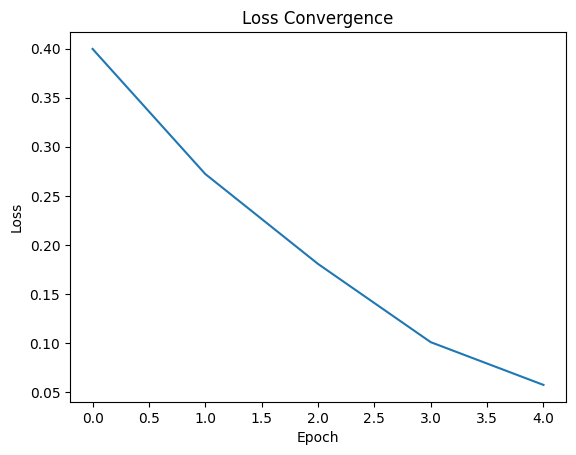

In [19]:
# Plot loss convergence

plt.plot(history_fth.history['loss'])
plt.title('Loss Convergence')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

We can see that the loss is converging as the number of epochs increases.

In [20]:
# Make predictions on test set

inputs = tokenizer.batch_encode_plus(list(X_test), 
                                     add_special_tokens=True, max_length=max_length, 
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

input_test = [np.asarray(inputs['input_ids'], dtype='int32'), 
              np.asarray(inputs['attention_mask'], dtype='int32')]

y_pred_fth = bert_model_fth.predict(input_test)
y_pred_fth = np.argmax(y_pred_fth, axis=1)
get_metrics(y_test, y_pred_fth, verbose=True)

782/782 [==============================] - 92s 115ms/step
Precision: 83.26
Recall: 89.10
F1: 86.08


In [39]:
# Error analysis

max_length = 100

text1 = [
    'this is such an amazing movie!',  
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

text2 = ["I was waiting for this day for the longest time. I was a kid back in 2009 when this movie released. So never got to watch it back then. But now when it rereleased I booked the first day show to a IMAX show and oh boy was I blown away! This is nothing short of a masterpiece! It's beyond belief how a film like this could've been made. Every scene, every shot is perfection. You are transferred to a different world and become so engrossed in the film. Never have I attended a movie where at the end of it people got up from their seats and started clapping! Last time this happened was after Infinity War. That movie too was a damn brilliant one. I'm from India and this is legit rare, where people go crazy, so crazy after any English film. This was one experience that I will never forget. I'm definitely going for it again next weekend cuz just once was not enough.",
"Forgive me, I'm going to jump from professional to fan boy for a while here. I haven't had the jitters after a film the way I've had for Avatar in quite sometime. James Cameron's Avatar is the most entertaining and enthralling cinematic experiences of my life. It is incredible, simply put. What Cameron has done here is the most passionate film project put out since Steven Spielberg released Schindler's List. His attention to detail and his zeal for pushing the envelope is so admirable to any filmmaker or actor who will ever do another film from this point on.",
"The plot is stolen from many different movies, there was only 3 good actors, the characters are either bland or stereotypical, and yet it made almost 3 billion. When I think a film is overrated I usually like it. I don't think of it as Oscar worthy, but I like it. Then there is Avatar a film I not only think is the most overrated film in history, but also on its own without the hype a terrible movie. It didn't have any effort put into the story at all. Star Wars took the ideas of many movies together to create something epic, but Avatar takes instead of being inspired by these things is just being lazy by stealing the ideas. It is an awful movie, but people and critics liked it. Why is that? Well that is due to the effects. Few watching, or reviewing cared about what the story was. All they cared about was the effects. Yes the effects and 3-D are great, but without the substance of a well written story it fails. I don't care if the effects are the best ever. Giving this film a good review based of the effects is like walking to your computer, and staring at the screensaver. You think it looks cool so you look at it. Next time you look up it is 3 hours later. Would consider that a good way to spend your time. No you would not, but you think that Avatar is worth your time. This a movie that is destroying filmmaking.",
"Avatar is a poorly written, and poorly acted animated movie. James Cameron directs Avatar like he would a TV movie. There's no real depth and no real emotion. The special effects aren't even all that great, and the 3-D is absolutely, 100% terrible."
 ]


inputs = tokenizer.batch_encode_plus(list(text2), 
                                     add_special_tokens=True, max_length=max_length, 
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

input_test = [np.asarray(inputs['input_ids'], dtype='int32'), 
              np.asarray(inputs['attention_mask'], dtype='int32')]
              
y = bert_model_fth.predict(input_test)
y = np.argmax(y, axis=1)
y

1/1 [==============================] - 0s 76ms/step


array([1, 1, 1, 0])

In thise case, the error analysis shows that the model is not predicting well with the more complex examples, in particular the third. However, it is the model with the best performance considering all the metrics. 

## 2. Bias analysis

One way to perform the bias analysis is comparing the predictions from the models on the reviews that contains words related to gender and with the actual labels of those reviews. 

In [29]:
# Create two subsets of the test data: one containing only reviews that mention male characters, and one containing only reviews that mention female characters

male_idxs = [idx for idx, review in enumerate(X_test) if "he" in review.lower() or "his" in review.lower() or "him" in review.lower()]# or "man" in review.lower() or "men" in review.lower()]
female_idxs = [idx for idx, review in enumerate(X_test) if "she" in review.lower() or "her" in review.lower() or "hers" in review.lower()]# or "woman" in review.lower() or "women" in review.lower()]

X_test_male = [X_test[i] for i in male_idxs]
y_test_male = y_test[male_idxs]
y_pred_fth_male = y_pred_fth[male_idxs]
y_pred_dbun_male = y_pred_dbun[male_idxs]
y_pred_bert_male = y_pred_bert[male_idxs]


X_test_female = [X_test[i] for i in female_idxs]
y_test_female = y_test[female_idxs]
y_pred_fth_female = y_pred_fth[female_idxs]
y_pred_dbun_female = y_pred_dbun[female_idxs]
y_pred_bert_female = y_pred_bert[female_idxs]

# Evaluate the model's performance on each subset separately

print("BERT - Performance on reviews mentioning male characters:")
metrics_male = get_metrics(y_test_male, y_pred_bert_male)

print("BERT - Performance on reviews mentioning female characters:")
metrics_female = get_metrics(y_test_female, y_pred_bert_female)

print("DistilBERT uncased- Performance on reviews mentioning male characters:")
metrics_male = get_metrics(y_test_male, y_pred_dbun_male)

print("DistilBERT uncased- Performance on reviews mentioning female characters:")
metrics_female = get_metrics(y_test_female, y_pred_dbun_female)

print("DistilBERT - Performance on reviews mentioning male characters:")
metrics_male = get_metrics(y_test_male, y_pred_fth_male)

print("DistilBERT - Performance on reviews mentioning female characters:")
metrics_female = get_metrics(y_test_female, y_pred_fth_female)


BERT - Performance on reviews mentioning male characters:
Precision: 78.71
Recall: 84.80
F1: 81.64
BERT - Performance on reviews mentioning female characters:
Precision: 77.48
Recall: 83.65
F1: 80.45
DistilBERT uncased- Performance on reviews mentioning male characters:
Precision: 79.21
Recall: 80.86
F1: 80.02
DistilBERT uncased- Performance on reviews mentioning female characters:
Precision: 77.98
Recall: 79.67
F1: 78.82
DistilBERT - Performance on reviews mentioning male characters:
Precision: 83.25
Recall: 89.09
F1: 86.07
DistilBERT - Performance on reviews mentioning female characters:
Precision: 82.08
Recall: 88.27
F1: 85.07


We can see that the performance of the different models is better for the reviews mentioning male characters than the ones mentioning female characters. One possible reason could be due to biased data or training. If the training data is skewed towards male reviews or male characters, the models may have learned to better predict sentiments for male reviews and characters, and therefore perform better on them.